In [153]:
import pandas as pd
import numpy as np
from sodapy import Socrata
import collections;
import re;
from time import time
from collections import defaultdict

from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import PassiveAggressiveClassifier

# Read Data Using API

In [2]:
client = Socrata("data.sfgov.org", None)
data = client.get("cuks-n6tp", limit = 3000000)
data_df = pd.DataFrame.from_records(data)

# Read data from CSV

In [3]:
# import pandas as pd

# data_df = pd.read_csv("./data/crimedata.csv");

In [4]:
# print(type(input))
# data_df = data_df.drop(data_df.columns[0], axis=1)

In [5]:
print(type(data_df))
print(data_df.shape)

<class 'pandas.core.frame.DataFrame'>
(2207110, 13)


In [6]:
print(data_df[:2])

                       address       category                     date  \
0  5400 Block of CALIFORNIA ST  VEHICLE THEFT  2015-08-29T00:00:00.000   
1     2300 Block of MISSION ST  DRUG/NARCOTIC  2017-06-22T00:00:00.000   

  dayofweek                                    descript incidntnum  \
0  Saturday                    ATTEMPTED STOLEN VEHICLE  150757654   
1  Thursday  UNDER INFLUENCE OF DRUGS IN A PUBLIC PLACE  170508857   

                                            location pddistrict  \
0  {u'type': u'Point', u'coordinates': [-122.4759...   RICHMOND   
1  {u'type': u'Point', u'coordinates': [-122.4190...    MISSION   

             pdid      resolution   time                    x  \
0  15075765407051            NONE  13:51    -122.475917940378   
1  17050885719095  ARREST, BOOKED  16:15  -122.41905886810274   

                   y  
0   37.7843496645156  
1  37.75942275062966  


In [7]:
data_df.sort_values(by=['date', 'time'])
# data_df.to_csv('./data/crimedata.csv', sep= ",", encoding="utf8")

,address,category,date,dayofweek,descript,incidntnum,location,pddistrict,pdid,resolution,time,x,y
641420,2600 Block of BRYANT ST,"SEX OFFENSES, FORCIBLE",2003-01-01T00:00:00.000,Wednesday,CHILD ABUSE SEXUAL,021623770,"{u'type': u'Point', u'coordinates': [-122.4089...",MISSION,2162377014015,UNFOUNDED,00:01,-122.408983439759,37.751987040935
643818,400 Block of BROADWAY ST,NON-CRIMINAL,2003-01-01T00:00:00.000,Wednesday,LOST PROPERTY,030011237,"{u'type': u'Point', u'coordinates': [-122.4050...",CENTRAL,3001123771000,NONE,00:01,-122.405065483077,37.7980134745487
645447,GEARY BL / 17TH AV,NON-CRIMINAL,2003-01-01T00:00:00.000,Wednesday,LOST PROPERTY,030018409,"{u'type': u'Point', u'coordinates': [-122.4761...",RICHMOND,3001840971000,NONE,00:01,-122.476169109518,37.7804745331212
649734,2600 Block of BRYANT ST,ASSAULT,2003-01-01T00:00:00.000,Wednesday,CHILD ABUSE (PHYSICAL),021623770,"{u'type': u'Point', u'coordinates': [-122.4089...",MISSION,2162377015015,UNFOUNDED,00:01,-122.408983439759,37.751987040935
650028,0 Block of LAFAYETTE ST,SUSPICIOUS OCC,2003-01-01T00:00:00.000,Wednesday,SUSPICIOUS OCCURRENCE,030320997,"{u'type': u'Point', u'coordinates': [-122.4166...",SOUTHERN,3032099764070,NONE,00:01,-122.416608653757,37.7725681063387
651363,3RD ST / CARGO WY,NON-CRIMINAL,2003-01-01T00:00:00.000,Wednesday,LOST PROPERTY,030000638,"{u'type': u'Point', u'coordinates': [-122.3871...",BAYVIEW,3000063871000,NONE,00:01,-122.387177992928,37.7461569686668
655752,10TH AV / GEARY BL,NON-CRIMINAL,2003-01-01T00:00:00.000,Wednesday,LOST PROPERTY,030365034,"{u'type': u'Point', u'coordinates': [-122.4685...",RICHMOND,3036503471000,NONE,00:01,-122.468564162408,37.7808215195192
657174,1700 Block of 21ST AV,SUSPICIOUS OCC,2003-01-01T00:00:00.000,Wednesday,SUSPICIOUS OCCURRENCE,030322341,"{u'type': u'Point', u'coordinates': [-122.4787...",TARAVAL,3032234164070,UNFOUNDED,00:01,-122.478747875056,37.7550587958463
659844,1800 Block of PINE ST,LARCENY/THEFT,2003-01-01T00:00:00.000,Wednesday,GRAND THEFT FROM A BUILDING,030399970,"{u'type': u'Point', u'coordinates': [-122.4262...",NORTHERN,3039997006304,NONE,00:01,-122.426246092712,37.7888345695702
661809,800 Block of VALLEJO ST,NON-CRIMINAL,2003-01-01T00:00:00.000,Wednesday,LOST PROPERTY,030064606,"{u'type': u'Point', u'coordinates': [-122.4112...",CENTRAL,3006460671000,NONE,00:01,-122.411280852294,37.798212742643


In [8]:
print(data_df.shape)

(2207110, 13)


In [9]:
for col in data_df.columns:
    print(col)

address
category
date
dayofweek
descript
incidntnum
location
pddistrict
pdid
resolution
time
x
y


# Preprocessing

In [10]:
def convert_date_to_day(dt):
    result = re.findall(r'\d{4}-(\d{2})-(\d{2})T00:00:00.000',dt)
    return result[0][1]
   
def convert_date_to_month(dt):
    result = re.findall(r'\d{4}-(\d{2})-(\d{2})T00:00:00.000',dt)
    return result[0][0]

def convert_time_to_hour(tm):
    result = re.findall(r'(\d{2}):\d{2}',tm)
    return result[0]

# def convert_date_to_year(dt):
#     result = re.findall(r'\d{4}-(\d{2})-(\d{2})T00:00:00.000',dt)
#     return result[0][0]

In [11]:
data_df = data_df.dropna(how='any',axis=0)
print(data_df[:1])

                       address       category                     date  \
0  5400 Block of CALIFORNIA ST  VEHICLE THEFT  2015-08-29T00:00:00.000   

  dayofweek                  descript incidntnum  \
0  Saturday  ATTEMPTED STOLEN VEHICLE  150757654   

                                            location pddistrict  \
0  {u'type': u'Point', u'coordinates': [-122.4759...   RICHMOND   

             pdid resolution   time                  x                 y  
0  15075765407051       NONE  13:51  -122.475917940378  37.7843496645156  


In [12]:
data_df['day'] = data_df.date.apply(lambda x: convert_date_to_day(x))
data_df['month'] = data_df.date.apply(lambda x: convert_date_to_month(x))
# data_df['year'] = data_df.date.apply(lambda x: convert_date_to_year(x))
data_df['hour'] = data_df.time.apply(lambda x: convert_time_to_hour(x))
data_df = data_df.sort_values(by=['date','time'])


In [13]:
# df = data_df.drop(['incidntnum','pdid','resolution','x','y', 'date', 'time', 'descript'], axis =1)
df = data_df.drop(['incidntnum','pdid','resolution','date', 'time', 'descript', 'location'], axis =1)
# df = df.drop(df.columns[[0]], axis =1)

for col in df.columns:
    print(col)

address
category
dayofweek
pddistrict
x
y
day
month
hour


In [14]:
# df.sort_values(by=['date'])
df['category'] = df.category.apply(lambda x: x.lower())
df['dayofweek'] = df.dayofweek.apply(lambda x: x.lower())
df['address'] = df.address.apply(lambda x: x.lower())
df['pddistrict'] = df.pddistrict.apply(lambda x: x.lower())

In [79]:
df['x'] = df.x.apply(lambda x: round(float(x),2))
df['y'] = df.y.apply(lambda y: round(float(y),2))

# Unique Crime Categories

In [16]:
uniqe_crime = {}
i = 0
for index,row in df.iterrows():
    if row['category'] not in uniqe_crime.keys():
        uniqe_crime[row['category']] = i
        i = i+1
    

In [17]:
print(len(uniqe_crime))
print(uniqe_crime)

39
{u'weapon laws': 28, u'recovered vehicle': 37, u'secondary codes': 15, u'warrants': 13, u'prostitution': 6, u'drug/narcotic': 20, u'embezzlement': 9, u'trespass': 23, u'bribery': 32, u'driving under the influence': 22, u'non-criminal': 1, u'sex offenses, non forcible': 24, u'disorderly conduct': 19, u'other offenses': 7, u'runaway': 29, u'suicide': 33, u'liquor laws': 31, u'sex offenses, forcible': 0, u'vehicle theft': 17, u'vandalism': 11, u'gambling': 34, u'pornography/obscene mat': 36, u'kidnapping': 26, u'family offenses': 35, u'assault': 2, u'larceny/theft': 4, u'burglary': 14, u'missing person': 16, u'forgery/counterfeiting': 5, u'extortion': 12, u'fraud': 8, u'arson': 30, u'trea': 38, u'bad checks': 25, u'loitering': 10, u'stolen property': 27, u'robbery': 21, u'suspicious occ': 3, u'drunkenness': 18}


In [18]:
# Define Index Crimes (More Serious)
index_crimes = ['ROBBERY', 'BURGLARY', 'LARCENY/THEFT', 'ASSAULT', 'ARSON', 'SEX OFFENSES, FORCIBLE', 'SECONDARY CODES',  'RECOVERED VEHICLE']
print(len(index_crimes))

# Define Non-Index Crimes (Less Serious)
non_index_crimes = ['OTHER OFFENSES', 'VEHICLE THEFT', 'NON-CRIMINAL', 'SUSPICIOUS OCC', 'FRAUD', 'FORGERY/COUNTERFEITING', 'WARRANTS', 'VANDALISM', 'MISSING PERSON', 'DISORDERLY CONDUCT', 'TRESPASS', 'WEAPON LAWS', 'DRUG/NARCOTIC', 'STOLEN PROPERTY', 'DRUNKENNESS', 'EMBEZZLEMENT', 'LOITERING', 'DRIVING UNDER THE INFLUENCE', 'PROSTITUTION', 'LIQUOR LAWS', 'EXTORTION', 'RUNAWAY', 'SUICIDE', 'BAD CHECKS', 'KIDNAPPING', 'FAMILY OFFENSES', 'BRIBERY', 'GAMBLING', 'SEX OFFENSES, NON FORCIBLE', 'PORNOGRAPHY/OBSCENE MAT', 'TREA']
len(non_index_crimes)

8


31

# Find Severity

In [19]:
severity = []
for index, row in df.iterrows():
    if row['category'].upper() in index_crimes:
        severity.append('INDEX')
#         print(row['category'], ": Index Crime (More Serious)")
    else:
        severity.append('NONINDEX')
#         print(row['category'], " : None Index Crime (More Serious)")

In [20]:
print(len(severity))
print(df.shape)

2207109
(2207109, 9)


In [21]:
df['severity'] = severity

In [22]:
print(df['category'][:10])
print(df['severity'][:10])

641420    sex offenses, forcible
643818              non-criminal
645447              non-criminal
649734                   assault
650028            suspicious occ
651363              non-criminal
655752              non-criminal
657174            suspicious occ
659844             larceny/theft
661809              non-criminal
Name: category, dtype: object
641420       INDEX
643818    NONINDEX
645447    NONINDEX
649734       INDEX
650028    NONINDEX
651363    NONINDEX
655752    NONINDEX
657174    NONINDEX
659844       INDEX
661809    NONINDEX
Name: severity, dtype: object


In [23]:
print(df.shape)

(2207109, 10)


# Label Encoding to convert string to int

In [24]:
lnc = LabelEncoder()


In [25]:
def perform_label_encoding(temp_df):
    temp = lnc.fit_transform(temp_df.dayofweek.iloc[:].values)
    temp_df['dayofweek'] = temp
    temp = lnc.fit_transform(temp_df.address.iloc[:].values)
    temp_df['address'] = temp
    temp = lnc.fit_transform(temp_df.category.iloc[:].values)
    temp_df['category'] = temp
    return temp_df

In [80]:
df = perform_label_encoding(df)
print(type(df))
print(df.shape)
print(df[:5])
# perform_label_encoding(sev_df)

<class 'pandas.core.frame.DataFrame'>
(2207109, 10)
        address  category  dayofweek pddistrict       x      y day month hour  \
641420     7947        28          6    mission -122.41  37.75  01    01   00   
643818    10241        20          6    central -122.41  37.80  01    01   00   
645447    17280        20          6   richmond -122.48  37.78  01    01   00   
649734     7947         1          6    mission -122.41  37.75  01    01   00   
650028      887        32          6   southern -122.42  37.77  01    01   00   

        severity  
641420     INDEX  
643818  NONINDEX  
645447  NONINDEX  
649734     INDEX  
650028  NONINDEX  


# Categorize all data by district in dictionary

In [81]:
series = df.groupby('pddistrict').apply(list)
dictionary = {}

In [82]:
series = df.groupby('pddistrict').apply(list)
dictionary = {}
city_target = df.get('severity').tolist()
unique_target=set(city_target)
print(len(unique_target))
print(len(city_target))

2
2207109


In [83]:
for s in series.keys():
    print(str(s))
    mask = df['pddistrict'] == str(s)
#     print(df[mask])
    dictionary[str(s)] = df[mask]

bayview
central
ingleside
mission
northern
park
richmond
southern
taraval
tenderloin


In [84]:
# for s in series.keys():
#     print(str(s))
#     mask = sev_df['pddistrict'] == str(s)
# #     print(df[mask])
#     dictionary[str(s)] = sev_df[mask]


In [85]:
print(type(dictionary['central']))
print(dictionary.keys())

<class 'pandas.core.frame.DataFrame'>
['central', 'northern', 'ingleside', 'park', 'mission', 'tenderloin', 'richmond', 'taraval', 'bayview', 'southern']


# Method to fetch District data

In [90]:
def fetchDistrictData(district):
    target = (dictionary.get(district))['severity']
    tempdf = (dictionary.get(district)).drop(['pddistrict', 'severity', 'category'], axis =1)
    return tempdf, target

In [91]:
# def fetchDistrictData(district):
#     target = (dictionary.get(district))['category']
#     tempdf = (dictionary.get(district)).drop(['pddistrict', 'category','severity'], axis =1)
#     return tempdf, target

In [92]:
district_bayview, district_bayview_target = fetchDistrictData('bayview')
print(len(district_bayview_target))
# print(district_bayview)

220292


In [93]:
# print(district_bayview.shape)
# print(district_bayview[:5])
print(len(set(district_bayview_target)))

2


# Method to generate train and test data

In [116]:
def fetchTrainTestData(district_df, district_target):
    X_train, X_test, y_train, y_test = train_test_split(district_df, district_target, test_size=0.20, random_state=42)
    print(X_train.shape)
    print(X_test.shape)
    print(y_train.shape)
    print(y_test.shape)
    return X_train, X_test, y_train, y_test


In [117]:
# X_train, X_test, y_train, y_test = fetchTrainTestData(mat_bayview, district_bayview_target)
# X_train, X_test, y_train, y_test = fetchTrainTestData(district_bayview, district_bayview_target)

In [118]:
# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)
# print(type(X_train))
# print(type(X_test))
# print(type(y_train))
# print(type(y_test))

In [119]:
# X_train_list = X_train.values.tolist()
# X_test_list = X_test.values.tolist()

In [120]:
# print(X_train[:10])
# print(X_test[:10])

# Method for classification

In [121]:
def classify(clf, X_train, Y_train, X_test):
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, Y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)
    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)
    print(type(pred))
    return pred

In [122]:
# from sklearn.preprocessing import StandardScaler
# X_train_std = StandardScaler().fit_transform(X_train.values.tolist())
# X_test_std = StandardScaler().fit_transform(X_train.values.tolist())

In [123]:
# pred = classify(tree.DecisionTreeClassifier(), X_train, y_train, X_test)
# pred = classify(RandomForestClassifier(), X_train, y_train, X_test)
# pred = classify(KNeighborsClassifier(n_neighbors=3), X_train, y_train, X_test)
# pred = classify(AdaBoostClassifier(), X_train, y_train, X_test)

In [174]:
def predictCrimeCategory(city, obj):
    district_df, district_target = fetchDistrictData(city)
    X_train, X_test, y_train, y_test = fetchTrainTestData(district_df, district_target)
    pred = classify(obj, X_train, y_train, X_test)
    score = f1_score(y_test, pred, average='macro')
    return pred, score

In [175]:
def writeToFile(pred, path):
    print(path)
    with open(path,'w+') as f:
        for p in pred:
            f.write(str(p)+"\n")

In [176]:
def classifyAllDistricts(clf, path = ""):
    dict_district_acc = {}
    dict_district_pred = {}
    dict_district_test = {}
    for key in dictionary.keys():
        pred, score, y_test = predictCrimeCategory(key, clf)
        dict_district_acc[key] = score
        dict_district_pred[key] = pred
        dict_district_test[key] = y_test
        writeToFile(pred, path+key+".dat")
    print(dict_district_acc)
    return dict_district_acc, dict_district_pred
#         

In [139]:
decisiontree_parameters = {
    'splitter':['best','random'],
    'criterion' : ['gini','entropy'],
    'max_features' : ['auto', 'sqrt', 'log2'],
    }
neighbor_params = {
    'n_neighbors': [2, 3, 4], 
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}
randomforest_parameters = {
    'n_estimators':[10,20],
    'max_depth' : [None,50,70]
    }

In [254]:
# # #Decision Tree
# clf = GridSearchCV(tree.DecisionTreeClassifier(), decisiontree_parameters)
knn_pred1, knn_score1 = predictCrimeCategory('tenderloin', KNeighborsClassifier(n_neighbors = 3))
print(pred, score)

(152976, 7)
(38244, 7)
(152976,)
(38244,)
Training: 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')
train time: 0.522s
test time:  0.526s
<type 'numpy.ndarray'>
(array(['NONINDEX', 'NONINDEX', 'NONINDEX', ..., 'NONINDEX', 'NONINDEX',
       'INDEX'], dtype=object), 0.44470900968795801)


In [255]:
tree_pred1, tree_score1 = predictCrimeCategory('tenderloin', GridSearchCV(tree.DecisionTreeClassifier(), decisiontree_parameters))

(152976, 7)
(38244, 7)
(152976,)
(38244,)
Training: 
GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': ['auto', 'sqrt', 'log2'], 'splitter': ['best', 'random'], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)
train time: 25.659s
test time:  0.049s
<type 'numpy.ndarray'>


In [257]:
forest_pred1, forest_score1 = predictCrimeCategory('tenderloin', GridSearchCV(RandomForestClassifier(), randomforest_parameters))

(152976, 7)
(38244, 7)
(152976,)
(38244,)
Training: 
GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 20], 'max_depth': [None, 50, 70]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)
train time: 42.276s
test time:  0.256s
<type 'numpy.ndarray'>


In [258]:
print(knn_score1, tree_score1)

(0.60647744873004383, 0.62271553573210947)


In [168]:
# knn_acc, knn_pred,  = classifyAllDistricts(KNeighborsClassifier(n_neighbors = 3), "./data/kneighbour/")

In [167]:
# decisiontree_acc, decisiontree_pred = classifyAllDistricts(GridSearchCV(tree.DecisionTreeClassifier(), decisiontree_parameters), "./data/decisiontree/")

In [166]:
# randomforest_acc, randomforest_pred = classifyAllDistricts(GridSearchCV(RandomForestClassifier(), randomforest_parameters), "./data/randomforest/")

In [ ]:
# pred = classify(tree.DecisionTreeClassifier(), X_train, y_train, X_test)
# pred = classify(RandomForestClassifier(), X_train, y_train, X_test)
# pred = classify(KNeighborsClassifier(n_neighbors=3), X_train, y_train, X_test)
# pred = classify(AdaBoostClassifier(), X_train, y_train, X_test)

In [159]:
final_pred = {}

In [169]:
# for key in dictionary.keys():
# #     print(key)
#     pred_knn = kneighbor_pred.get(key)
#     pred_dtree = decisiontree_pred.get(key)
#     pred_forest = randomforest_pred.get(key)
#     ind = 0
#     non_ind = 0
#     list = []
#     length = len(pred_dtree)
#     print(length)
#     for i in range(length):
#         if pred_knn[i] is "INDEX":
#             ind+=1
#         else:
#             non_ind+=1
#         if pred_dtree[i] is "INDEX":
#             ind+=1
#         else:
#             non_ind+=1            
#         if pred_forest[i] is "INDEX":
#             ind+=1
#         else:
#             non_ind+=1
#         if ind>non_ind:
#             list.append("INDEX")
#         else:
#             list.append("NONINDEX")
#     print(len(list))
#     print(list[:5])
# #     final_pred[key] = list

In [183]:
def generateAverageScore(kneighbor_pred, decisiontree_pred, randomforest_pred):
    list = []
    length = len(kneighbor_pred)
    print(length)
    for i in range(length):
        ind = 0
        non_ind = 0
        if kneighbor_pred[i] is "INDEX":
            ind+=1
        else:
            non_ind+=1
        if decisiontree_pred[i] is "INDEX":
            ind+=1
        else:
            non_ind+=1            
        if randomforest_pred[i] is "INDEX":
            ind+=1
        else:
            non_ind+=1
        if ind>non_ind:
            list.append("INDEX")
        else:
            list.append("NONINDEX")
    print(len(list))
    print(list[:5])
    return list
#     final_pred[key] = list

In [200]:
def ensamble_classifiers(district, city = False):
    #Fetch district data
    if city is True:
        district_target = df['severity']
        district_df = df.drop(['pddistrict', 'severity', 'category'], axis =1)
    else:
        district_df, district_target = fetchDistrictData(district)
    X_train, X_test, y_train, y_test = fetchTrainTestData(district_df, district_target)
    #Classifiers
    kneighbor_pred  = classify(KNeighborsClassifier(n_neighbors = 3), X_train, y_train, X_test)
    score1 = f1_score(y_test, kneighbor_pred, average='macro')
    print("KNN: ", score1)
    decisiontree_pred = classify(GridSearchCV(tree.DecisionTreeClassifier(), decisiontree_parameters), 
                                X_train, y_train, X_test)
    score2 = f1_score(y_test, decisiontree_pred, average='macro')
    print("Decision Tree: ", score2)
    randomforest_pred = classify(GridSearchCV(RandomForestClassifier(), randomforest_parameters), 
                                 X_train, y_train, X_test)
    score3 = f1_score(y_test, randomforest_pred, average='macro')
    print("Random Forest: ", score3)
    
    list = generateAverageScore(kneighbor_pred, decisiontree_pred, randomforest_pred)
    score = f1_score(y_test, list, average='macro')
    print(district ,"Final F1 Score: " , score )
    return score

In [261]:
def ensamble_classifiers_fetch_allscores(district, city = False):
    #Fetch district data
    if city is True:
        district_target = df['severity']
        district_df = df.drop(['pddistrict', 'severity', 'category'], axis =1)
    else:
        district_df, district_target = fetchDistrictData(district)
    X_train, X_test, y_train, y_test = fetchTrainTestData(district_df, district_target)
    #Classifiers
    kneighbor_pred  = classify(KNeighborsClassifier(n_neighbors = 3), X_train, y_train, X_test)
    score1 = f1_score(y_test, kneighbor_pred, average='macro')
    print("KNN: ", score1)
    decisiontree_pred = classify(GridSearchCV(tree.DecisionTreeClassifier(), decisiontree_parameters), 
                                X_train, y_train, X_test)
    score2 = f1_score(y_test, decisiontree_pred, average='macro')
    print("Decision Tree: ", score2)
    randomforest_pred = classify(GridSearchCV(RandomForestClassifier(), randomforest_parameters), 
                                 X_train, y_train, X_test)
    score3 = f1_score(y_test, randomforest_pred, average='macro')
    print("Random Forest: ", score3)
    
    list = generateAverageScore(kneighbor_pred, decisiontree_pred, randomforest_pred)
    score = f1_score(y_test, list, average='macro')
    print(district ,"Final F1 Score: " , score )
    scores = [score1, score2, score3, score]
    return scores

In [192]:
ensamble_district_acc = {}

In [193]:
for key in dictionary.keys():
    ensamble_district_acc[key] = ensamble_classifiers(key)

(180265, 7)
(45067, 7)
(180265,)
(45067,)
Training: 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')
train time: 0.485s
test time:  0.416s
<type 'numpy.ndarray'>
('KNN: ', 0.56988564351976767)
Training: 
GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': ['auto', 'sqrt', 'log2'], 'splitter': ['best', 'random'], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose

train time: 0.768s
test time:  0.715s
<type 'numpy.ndarray'>
('KNN: ', 0.5746936833959867)
Training: 
GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': ['auto', 'sqrt', 'log2'], 'splitter': ['best', 'random'], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)
train time: 42.864s
test time:  0.081s
<type 'numpy.ndarray'>
('Decision Tree: ', 0.58628733329954241)
Training: 
GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, c

train time: 31.081s
test time:  0.057s
<type 'numpy.ndarray'>
('Decision Tree: ', 0.59364363859592317)
Training: 
GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 20], 'max_depth': [None, 50, 70]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)
train time: 56.237s
test time:  0.318s
<type 'numpy.ndarray'>
('Decision Tree: ', 0.60060477224551256)
44059
44059
['INDEX', 'NONINDEX', 'NONINDEX', 'NONINDEX', 'NONINDEX']
('bayview',

In [202]:
city_acc = ensamble_classifiers(None, True)

(1765687, 7)
(441422, 7)
(1765687,)
(441422,)
Training: 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')
train time: 11.128s
test time:  10.044s
<type 'numpy.ndarray'>
('KNN: ', 0.57721171837572638)
Training: 
GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': ['auto', 'sqrt', 'log2'], 'splitter': ['best', 'random'], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, v

In [207]:
ensamble_district_acc['sanfrancisco'] = city_acc

In [233]:
ensamble_district_acc.pop('sanfrancisco')

0.60051363351134679

In [239]:
# print(ensamble_district_acc)
print(ensamble_district_acc.keys())
# print(ensamble_district_acc.values())

['central', 'northern', 'ingleside', 'park', 'mission', 'tenderloin', 'richmond', 'taraval', 'bayview', 'southern']


In [249]:
x_data = []
y_data = []

In [250]:
for key in ensamble_district_acc.keys():
    x_data.append(key)
    y_data.append(ensamble_district_acc.get(key))
x_data.append("City")
y_data.append(city_acc)

In [251]:
print(x_data)
print(y_data)

['central', 'northern', 'ingleside', 'park', 'mission', 'tenderloin', 'richmond', 'taraval', 'bayview', 'southern', 'City']
[0.59130693732167172, 0.59800476175272288, 0.58370895362060393, 0.59032958064002872, 0.5901522946761224, 0.629442482630722, 0.58674635263875363, 0.58864455360617829, 0.60374674890786295, 0.59580287963996881, 0.60051363351134679]


In [252]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

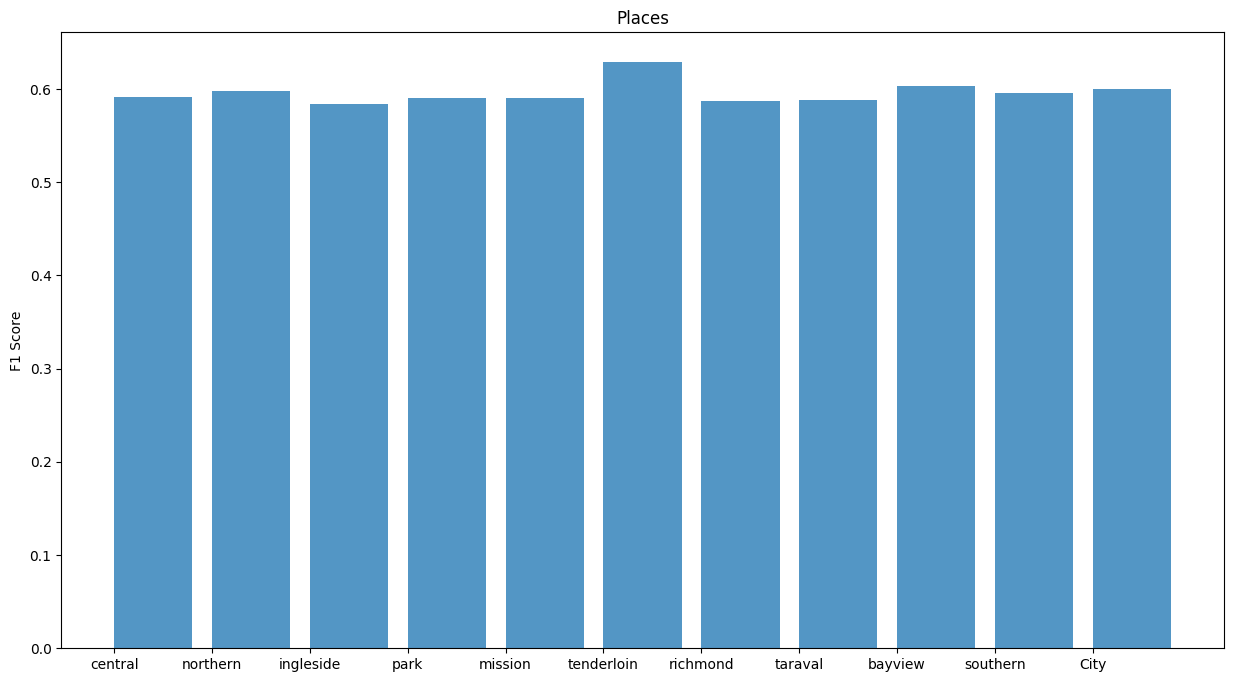

In [281]:
y_pos = np.arange(len(y_data))
 
plt.bar(y_pos, y_data, align='edge', alpha=0.767)
plt.xticks(y_pos, x_data, rotation=0)
plt.ylabel('F1 Score')
plt.title('Places')
plt.rcParams["figure.figsize"]=[16,8]
 
plt.show()

In [262]:
scores = ensamble_classifiers_fetch_allscores('tenderloin')

(152976, 7)
(38244, 7)
(152976,)
(38244,)
Training: 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')
train time: 0.525s
test time:  0.536s
<type 'numpy.ndarray'>
('KNN: ', 0.60647744873004383)
Training: 
GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': ['auto', 'sqrt', 'log2'], 'splitter': ['best', 'random'], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose

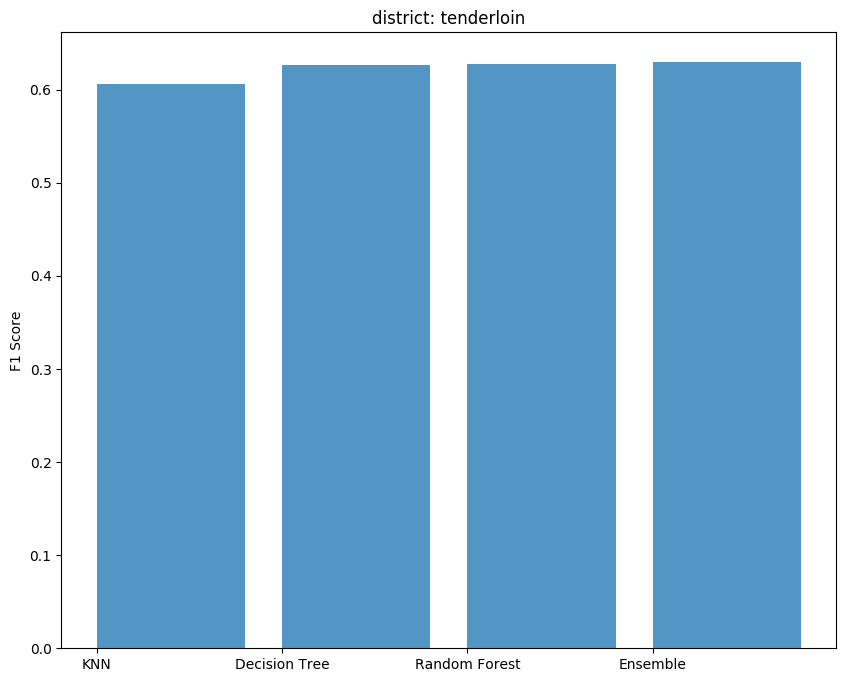

In [280]:
y_pos = np.arange(len(scores))
labels = ['KNN', 'Decision Tree', 'Random Forest', 'Ensemble']
plt.bar(y_pos, scores, align='edge', alpha=0.767)
plt.xticks(y_pos, labels, rotation=0)
plt.ylabel('F1 Score')
plt.title('district: tenderloin')
plt.rcParams["figure.figsize"]=[15,8] 
plt.show()

In [301]:
randomforest_parameters1 = {
    'n_estimators':[10,20],
    'max_depth' : [None,50,70]
    }
randomforest_parameters2 = {
    'n_estimators':[10,20],
    'max_depth' : [None,5,10]
    }

In [302]:
forest_pred2, forest_score2 = predictCrimeCategory('tenderloin', GridSearchCV(RandomForestClassifier(), 
                                                                              randomforest_parameters1))

(152976, 7)
(38244, 7)
(152976,)
(38244,)
Training: 
GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 20], 'max_depth': [None, 50, 70]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)
train time: 42.787s
test time:  0.263s
<type 'numpy.ndarray'>


In [303]:
forest_pred3, forest_score3 = predictCrimeCategory('tenderloin', GridSearchCV(RandomForestClassifier(), 
                                                                              randomforest_parameters2))

(152976, 7)
(38244, 7)
(152976,)
(38244,)
Training: 
GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 20], 'max_depth': [None, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)
train time: 29.421s
test time:  0.110s
<type 'numpy.ndarray'>


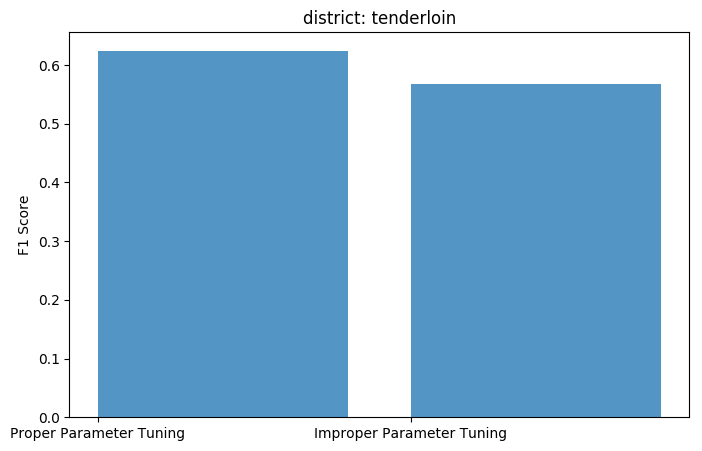

In [307]:
scores1 = [forest_score2, forest_score3]
y_pos = np.arange(len(scores1))
labels = ['Proper Parameter Tuning', 'Improper Parameter Tuning']
plt.bar(y_pos, scores1, align='edge', alpha=0.767)
plt.xticks(y_pos, labels, rotation=0)
plt.ylabel('F1 Score')
plt.title('district: tenderloin')
# plt.rcParams["figure.figsize"]=[8,5] 
plt.show()

In [308]:
print(scores1)

[0.62450268203776804, 0.56691576815776323]
